## Importing required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
%pip install wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Data

In [4]:
data = pd.read_csv("amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print("Dataset shape:", (data.shape))

Dataset shape: (3150, 5)


## Exploratory Data Analysis

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
# Columns names

print("Feature name:", data.columns.values)

Feature name: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [7]:
# Checking for null values

data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
# Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
# Dropping the null record

data.dropna(inplace = True)

In [10]:
# Shape of dataset after dropping the null value

print("Dataset shape:", (data.shape))

Dataset shape: (3149, 5)


In [11]:
# Creating a new column 'Lenght' that will contain the Length of the string in 'verified_reviews' column

data['Length'] = data['verified_reviews'].apply(lambda x: len(x))

In [12]:
data.head()

,rating,date,variation,verified_reviews,feedback,Length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [13]:
# datatypes of the features

data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
Length,int64


### Analysing the 'Rating' column

In [14]:
# Distinct values of 'rating' and its count
print(data['rating'].value_counts())

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


- rating, feedback and length are interger values
- date, variation and verified_reviews are string values

In [15]:
# total data
len(data)

3149

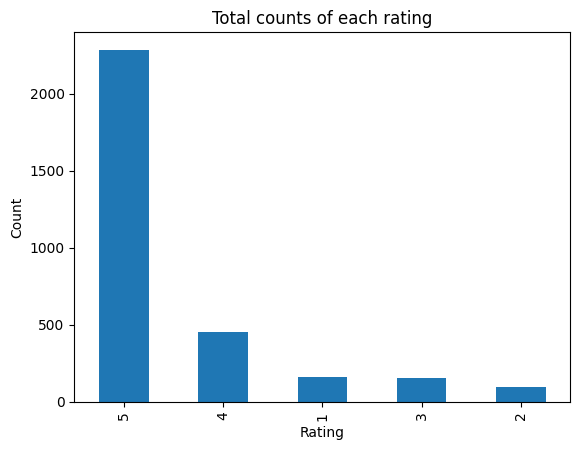

In [16]:
# Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot(kind = 'bar')
plt.title('Total counts of each rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
# Percentage of distribution of each rating

print("Rating value count - percentage distribution")
print(data['rating'].value_counts(normalize = True)*100)

Rating value count - percentage distribution
rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: proportion, dtype: float64


### Analysing the 'feedback' column

In [18]:
# Distinct values of 'feedback' and its count

print(data['feedback'].value_counts())

feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback', 0 and 1.

In [19]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [20]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that a 0 feedback corresponds to 'negative' reviews and a 1 feedback corresponds to a 'positive' review

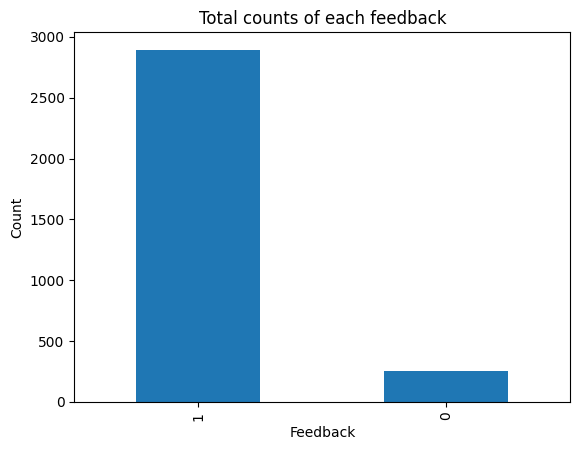

In [21]:
# Bar plot to visualize the total counts for each feedback

data['feedback'].value_counts().plot(kind = 'bar')
plt.title('Total counts of each feedback')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [22]:
# Percentage of distribution of feedback

print("Feedback value count - percentage distribution")
print(data['feedback'].value_counts(normalize = True)*100)

Feedback value count - percentage distribution
feedback
1    91.870435
0     8.129565
Name: proportion, dtype: float64


- 91.87% of the reviews are positive
- 8.12% of the reviews are negative

Rating values for different values of feedback

In [23]:
# Feedback = 0
data[data['feedback']== 0 ]['rating'].value_counts()

,count
rating,
1,161
2,95


In [24]:
# Feedback = 1
data[data['feedback']== 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


If the rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4, or 5 then the feedback is 1 (positive)

### Analysing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcol Fabric etc.

In [25]:
# Distinct values of the 'variation' column and its count

print(data['variation'].value_counts())

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


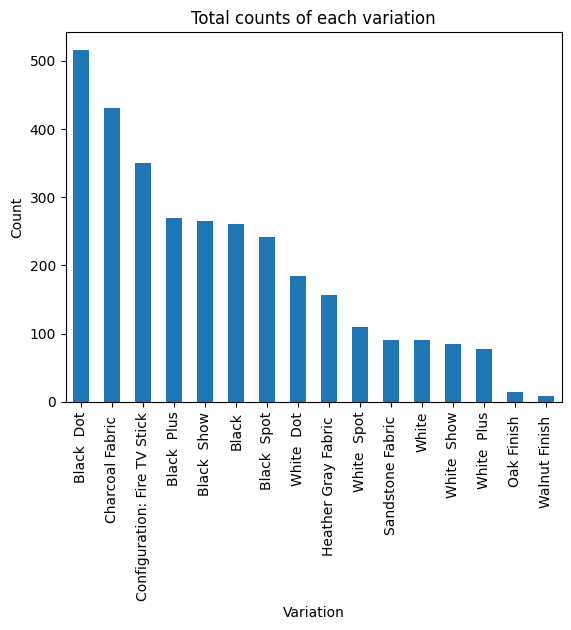

In [26]:
# Bar plot to visualise the total count of each variation

data['variation'].value_counts().plot(kind = 'bar')
plt.title('Total counts of each variation')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [27]:
# percentage of distribution of each variation
print("Variation value count - percentage distribution")
print(data['variation'].value_counts(normalize = True)*100)

Variation value count - percentage distribution
variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: proportion, dtype: float64


In [28]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


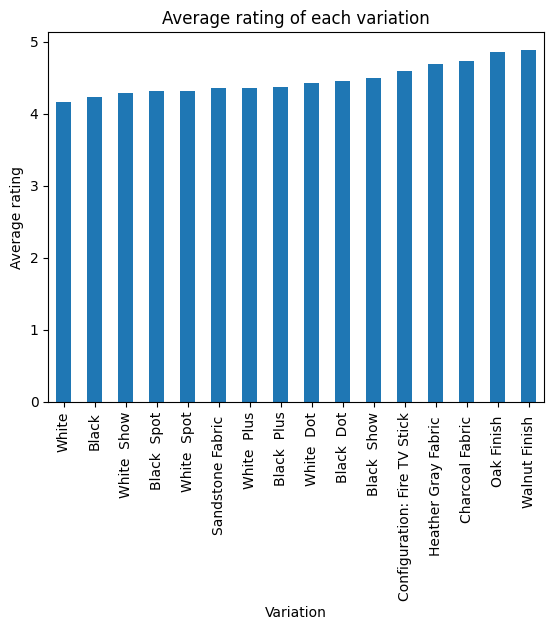

In [29]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar()
plt.title('Average rating of each variation')
plt.xlabel('Variation')
plt.ylabel('Average rating')
plt.show()

### Analysing 'verifiew_reviews' column

In [30]:
data['Length'].describe()

,Length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of length of reviews')]

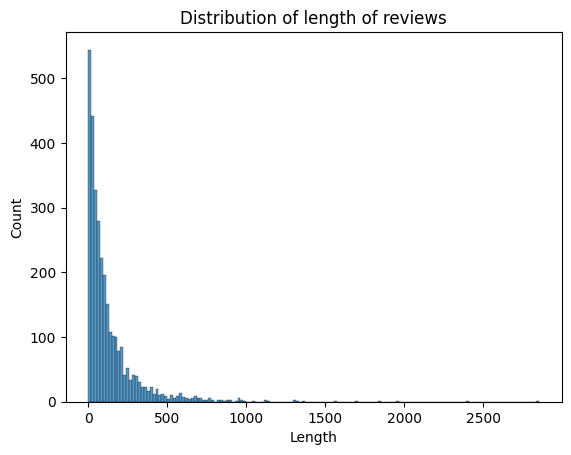

In [31]:
sns.histplot(data['Length']).set(title= 'Distribution of length of reviews')

[Text(0.5, 1.0, 'Distribution of length of negative reviews')]

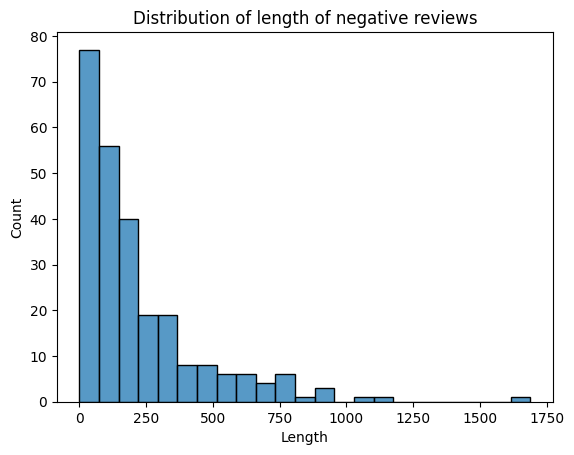

In [32]:
sns.histplot(data[data['feedback']==0]['Length']).set(title= 'Distribution of length of negative reviews')

[Text(0.5, 1.0, 'Distribution of length of positive reviews')]

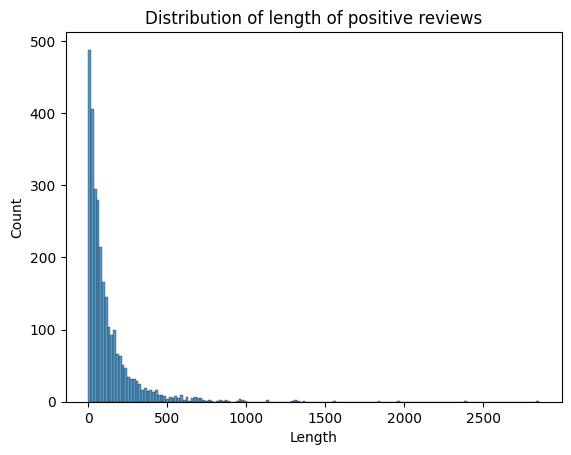

In [33]:
sns.histplot(data[data['feedback']==1]['Length']).set(title= 'Distribution of length of positive reviews')

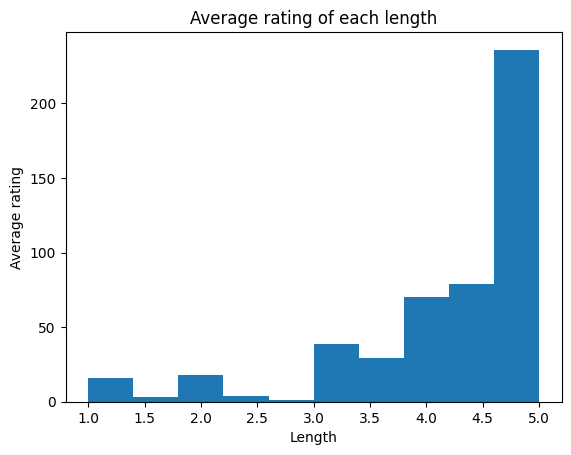

In [34]:
data.groupby('Length')['rating'].mean().plot.hist()
plt.title('Average rating of each length')
plt.xlabel('Length')
plt.ylabel('Average rating')
plt.show()

In [35]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

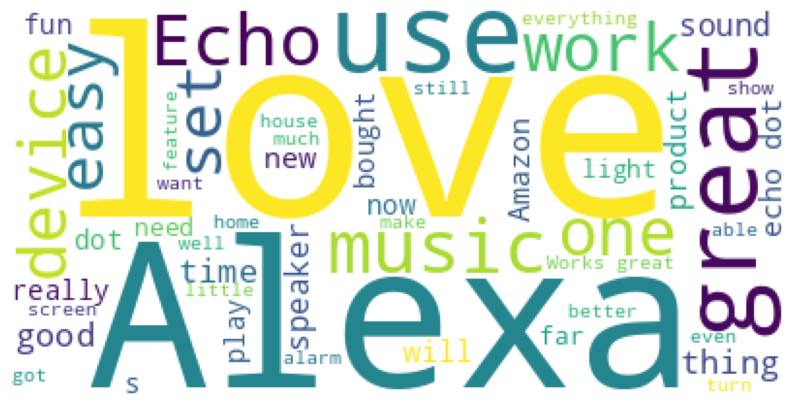

In [36]:
# Combining all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initializing wordcloud object
wc = WordCloud(background_color='white', max_words = 50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

In [37]:
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

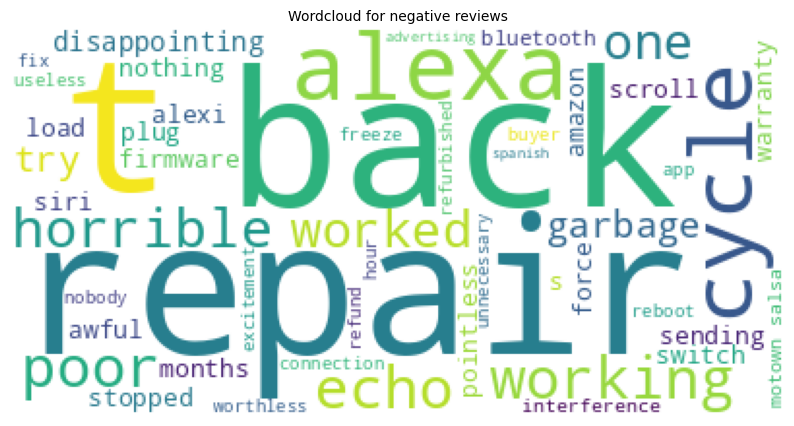

In [38]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

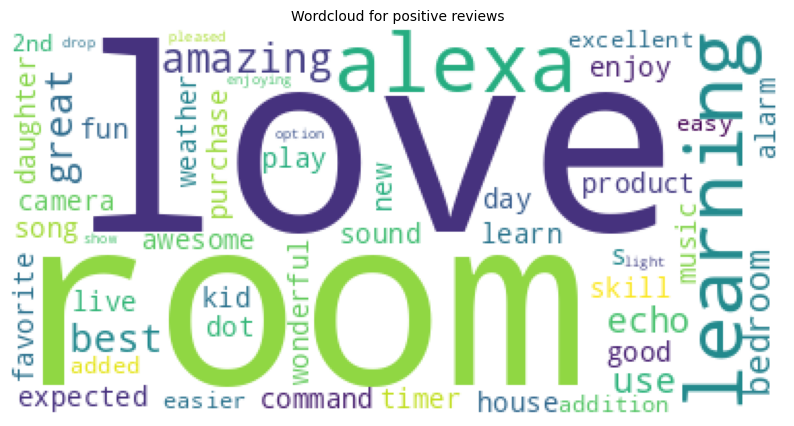

In [39]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modeling

To build the corpus from the 'verified_reviews' we perform the following -

- Replace any non alphabet characters with a space
- Covert to lower case and split into words
- Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [40]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [41]:
cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [42]:
import os
#Saving the Count Vectorizer
os.makedirs('Models', exist_ok=True)
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [43]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [44]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [45]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [46]:
# Scaling the data so that all values are between 0 and 1
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [47]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

### Random Forest

In [48]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [49]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9428571428571428


In [50]:
y_preds = model_rf.predict(X_test_scl)

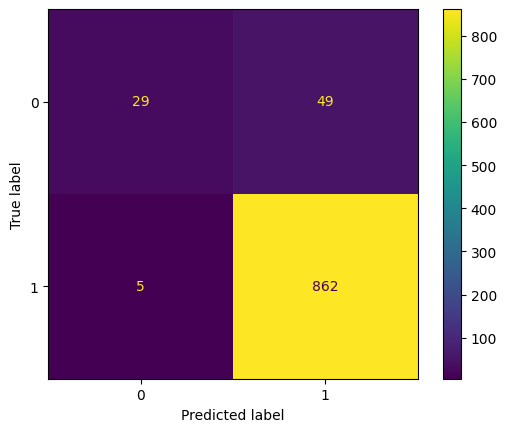

In [51]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [52]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9305820649938298
Standard Variance : 0.00786223381713492


Applying grid search to get the optimal parameters on random forest

In [53]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [54]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [55]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [56]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.80694192377494
Cross validation mean accuracy on test set : 92.15063520871144
Accuracy score for test set : 0.9428571428571428


XgBoost

In [57]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [58]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [59]:
y_preds = model_xgb.predict(X_test)

In [60]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


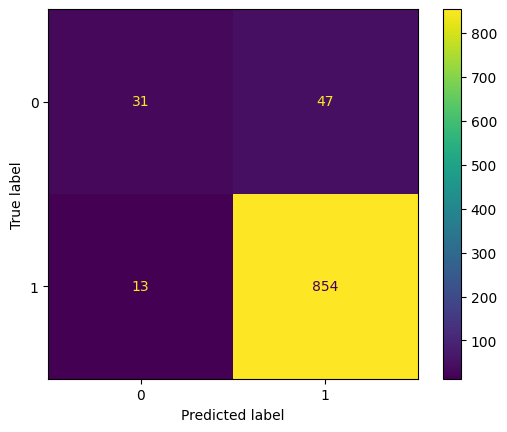

In [61]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [62]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

Decision Tree Classifier

In [63]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [64]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9238095238095239


In [65]:
y_preds = model_dt.predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 41  37]
 [ 67 800]]


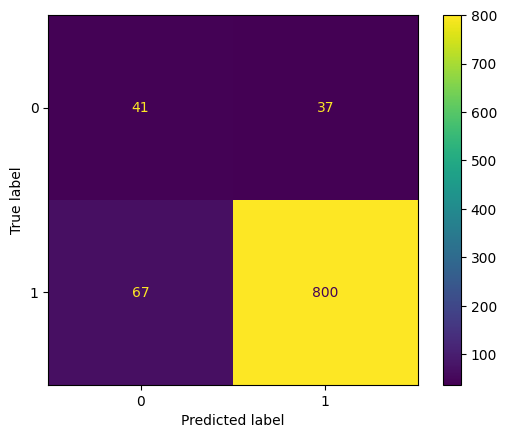

In [67]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()